In [19]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17671537360288316268
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 170459136
locality {
  bus_id: 1
}
incarnation: 9493394957667786037
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 338231296
locality {
  bus_id: 1
}
incarnation: 13832129856767949179
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:b3:00.0, compute capability: 6.1"
]


In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility


import gzip
import sys
if (sys.version_info > (3, 0)):
    import pickle as pkl
else: #Python 2.7 imports
    
    import cPickle as pkl

import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate
from keras.layers import Embedding
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.regularizers import Regularizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt

C:\Users\Aravindhan.Poopathy\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.utils import to_categorical

In [3]:
def wordIdxLookup(word, word_idx_map):
    if word in word_idx_map:
        return word_idx_map[word]

In [4]:
data = pkl.load(gzip.open("C:/Users/Aravindhan.Poopathy/OneDrive - So Energy/Arav/Sentence_classic_new-master/Sentence_classic_new-master/code/soeMailData/pkl/maildata.pkl.gz","rb"))
print("data loaded!")

data loaded!


In [56]:
train_labels = data['train']['labels']
train_sentences = data['train']['sentences']

dev_labels = data['dev']['labels']
dev_sentences = data['dev']['sentences']

test_labels = data['test']['labels']
test_sentences = data['test']['sentences']

word_embeddings = data['wordEmbeddings']

In [57]:
# :: Find the longest sentence in our dataset ::
max_sentence_len = 0
for sentence in train_sentences + dev_sentences + test_sentences:
    max_sentence_len = max(len(sentence), max_sentence_len)

print("Longest sentence: %d" % max_sentence_len)

Longest sentence: 704


In [58]:
y_train = np.array(train_labels)
y_dev = np.array(dev_labels)
y_test = np.array(test_labels)

X_train = sequence.pad_sequences(train_sentences, maxlen=max_sentence_len)
X_dev = sequence.pad_sequences(dev_sentences, maxlen=max_sentence_len)
X_test = sequence.pad_sequences(test_sentences, maxlen=max_sentence_len)


print('X_train shape:', X_train.shape)
print('X_dev shape:', X_dev.shape)
print('X_test shape:', X_test.shape)

X_train shape: (8094, 704)
X_dev shape: (4047, 704)
X_test shape: (4048, 704)


In [25]:
# #Change to float datatype:
# X_train = X_train.astype('float32')
# X_dev = X_dev.astype('float32')
# X_test = X_test.astype('float32')

In [26]:
# #Scale the data to lie between 0 to 1
# X_train /= 255
# X_dev /= 255
# X_test /= 255

In [59]:
import numpy as np
# labels = y_train.tolist() + y_dev.tolist() + y_test.tolist()
classes = np.unique(y_train)
nclasses = len(classes)
print('output clases : ', classes)
print('total number of output classes : ', nclasses)

output clases :  [0 1 2 3 4]
total number of output classes :  5


In [60]:
#converting the labels as one hot variables:
y_train_one_hot = to_categorical(y_train,nclasses)
y_dev_one_hot = to_categorical(y_dev,nclasses)
y_test_one_hot = to_categorical(y_test,nclasses)

In [61]:
# Display the change for category label using one-hot encoding# Displa 
print('Original label 0 : ', y_train[0])
print('After conversion to categorical ( one-hot ) : ', y_train_one_hot[0])

Original label 0 :  2
After conversion to categorical ( one-hot ) :  [0. 0. 1. 0. 0.]


In [84]:
#  :: Create the network :: 

print('Build model...')

# set parameters:
batch_size = 50

nb_filter = 50
filter_lengths = [1,2,3]
hidden_dims = 100
nb_epoch = 30



words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')

Build model...


In [85]:
[words_input]
# word_embeddings.shape[1]

[<tf.Tensor 'words_input_4:0' shape=(?, 704) dtype=int32>]

In [86]:
#Our word embedding layer
wordsEmbeddingLayer = Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1],                                     
                    weights=[word_embeddings],
                    trainable=False)

words = wordsEmbeddingLayer(words_input)


In [87]:
# wordsEmbeddingLayer
words

<tf.Tensor 'embedding_5/embedding_lookup:0' shape=(?, 704, 300) dtype=float32>

In [88]:
#Now we add a variable number of convolutions
words_convolutions = []
for filter_length in filter_lengths:
    words_conv = Convolution1D(filters=nb_filter,
                            kernel_size=filter_length,
                            padding='same',
                            activation='relu',
                            strides=1)(words)
                            
    words_conv = GlobalMaxPooling1D()(words_conv)      
    
    words_convolutions.append(words_conv)  

output = concatenate(words_convolutions)



# We add a vanilla hidden layer together with dropout layers:
output = Dropout(0.5)(output)
output = Dense(hidden_dims, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.01))(output)
output = Dropout(0.25)(output)


# We project onto a single unit output layer, and squash it with a sigmoid:
output = Dense(5, activation='softmax',  kernel_regularizer=keras.regularizers.l2(0.01))(output)

model = Model(inputs=[words_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 704)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 704, 300)     2187000     words_input[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 704, 50)      15050       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 704, 50)      30050       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_24 

In [89]:
# for epoch in range(nb_epoch):
# print("\n------------- Epoch %d ------------" % (epoch+1))

trModel = model.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=nb_epoch,
          verbose=1,validation_data=(X_dev,y_dev_one_hot))


Train on 8094 samples, validate on 4047 samples
Epoch 1/30
8094/8094 [==============================] - 86s 11ms/step - loss: 2.5430 - acc: 0.3216 - val_loss: 1.9347 - val_acc: 0.6504
Epoch 2/30
8094/8094 [==============================] - 91s 11ms/step - loss: 1.6745 - acc: 0.5703 - val_loss: 1.3059 - val_acc: 0.7102
Epoch 3/30
8094/8094 [==============================] - 82s 10ms/step - loss: 1.2322 - acc: 0.6723 - val_loss: 0.9926 - val_acc: 0.7850
Epoch 4/30
8094/8094 [==============================] - 84s 10ms/step - loss: 0.9882 - acc: 0.7314 - val_loss: 0.8134 - val_acc: 0.7981
Epoch 5/30
8094/8094 [==============================] - 87s 11ms/step - loss: 0.8697 - acc: 0.7566 - val_loss: 0.7304 - val_acc: 0.8080
Epoch 6/30
8094/8094 [==============================] - 89s 11ms/step - loss: 0.7885 - acc: 0.7755 - val_loss: 0.6888 - val_acc: 0.8070
Epoch 7/30
8094/8094 [==============================] - 90s 11ms/step - loss: 0.7410 - acc: 0.7908 - val_loss: 0.6424 - val_acc: 0.8228


In [90]:
#Use Keras to compute the loss and the accuracy
dev_loss, dev_accuracy = model.evaluate(X_dev, y_dev_one_hot, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=1)


print("Val-Accuracy: %.2f%% (loss: %.4f)" % (dev_accuracy*100, dev_loss))
print("Test-Accuracy: %.2f%% (loss: %.4f)" % (test_accuracy*100, test_loss))

4048/4048 [==============================] - 14s 3ms/step
Val-Accuracy: 85.69% (loss: 0.4887)
Test-Accuracy: 85.42% (loss: 0.4912)


Text(0.5,1,'Loss Curves')

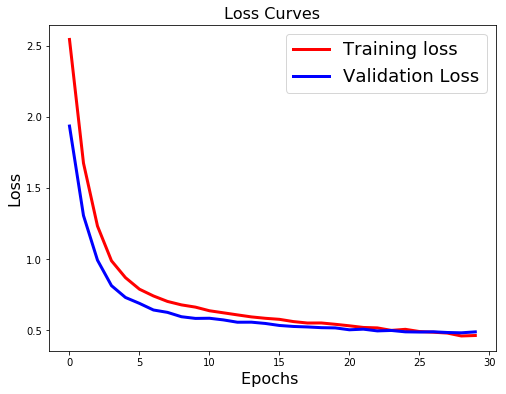

In [91]:
#Training Loss and Validation Loss
plt.figure(figsize=[8,6])
plt.plot(trModel.history['loss'],'r',linewidth=3.0)
plt.plot(trModel.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

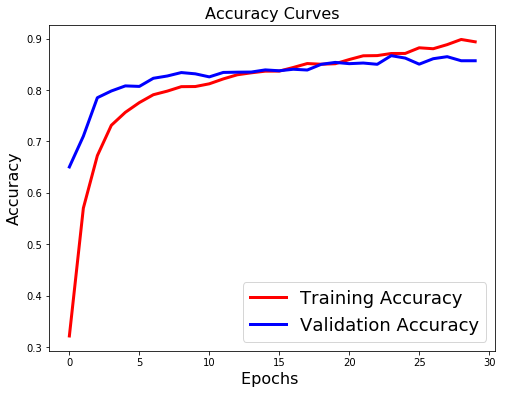

In [92]:
#Training Accuracy and Validation Accuracy
plt.figure(figsize=[8,6])
plt.plot(trModel.history['acc'],'r',linewidth=3.0)
plt.plot(trModel.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [93]:
preds = model.predict(X_test, batch_size=batch_size)

In [94]:
type(preds)

numpy.ndarray

In [95]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [103]:
preds[100]

array([0.08259081, 0.04873534, 0.00399024, 0.00216934, 0.8625142 ],
      dtype=float32)

In [104]:
y_test_one_hot[100]

array([0., 0., 0., 0., 1.], dtype=float32)

In [105]:
model.save("C:/Users/Aravindhan.Poopathy/OneDrive - So Energy/Arav/Sentence_classic_new-master/Sentence_classic_new-master/code/soeMailData/soemailModels/classMailModel1.h5")

In [106]:
from keras.models import load_model

loadedModel = load_model("C:/Users/Aravindhan.Poopathy/OneDrive - So Energy/Arav/Sentence_classic_new-master/Sentence_classic_new-master/code/soeMailData/soemailModels/classMailModel1.h5")

In [107]:
result_data = pkl.load(gzip.open("C:/Users/Aravindhan.Poopathy/OneDrive/Arav/Sentence_classic_new-master/Sentence_classic_new-master/code/pkl/resultdata.pkl.gz","rb"))
print("data loaded!")

data loaded!


In [108]:
result_data.tolist()

[[110,
  53,
  585,
  813,
  5201,
  14,
  2,
  1,
  118,
  1360,
  1207,
  9,
  8,
  813,
  27,
  11,
  1,
  61,
  3068,
  95,
  585,
  459,
  1036,
  984,
  118,
  5341,
  9,
  3576,
  9,
  2370,
  19,
  26,
  657]]

In [109]:
result_X = sequence.pad_sequences(result_data, maxlen=max_sentence_len)
# result_data.extend([0] * (59 - len(result_data)))

In [110]:
result_X

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [111]:
result_y_pred = loadedModel.predict(result_X, batch_size=batch_size)

In [112]:
result_y_pred.ravel()

array([0.15074295, 0.25583375, 0.56165683, 0.02903   , 0.00273646],
      dtype=float32)